In [1]:
%pylab inline
import gc
import galsim
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [7]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
psfFWHM=0.60
scale=0.168
igal=42
beta=0.75

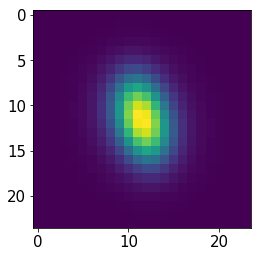

In [7]:
hsmCat=pyfits.getdata('galaxy_basic_psf%d/hsm-0-g1-2222.fits' %(psfFWHM*100))
rcutArray=np.maximum(np.minimum(np.int_(hsmCat['regauss_detR']*5),15),11)
rcut=rcutArray[igal]
    
beg=ngrid//2-rcut
end=beg+2*rcut
galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
img=galImgAll[igal//nx*ngrid+beg:igal//nx*ngrid+end,igal%nx*ngrid+beg:igal%nx*ngrid+end]/10.
plt.imshow(img)

In [8]:
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
fpTask0=fpfsBase.fpfsTask(psfData,beta=beta)

a0=fpTask0.measure(img)
C=1000
b0=fpfsBase.fpfsM2E(a0,C)
print(a0,a0.dtype.names)
print(b0,b0.dtype.names)

(12.53078177, 3.20816112, -1.90802405, 1.47132046) ('fpfs_M00', 'fpfs_M22c', 'fpfs_M22s', 'fpfs_M40')
[(0.00316846, -0.00188441, 0.00773305, 0.0123757, 1.35901297e-05, 9.4907464e-06)] ('fpfs_e1', 'fpfs_e2', 'fpfs_RE', 'fpfs_s0', 'fpfs_eSquare', 'fpfs_RS')


In [9]:
# Noise
corPre      =   'corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
variance    =   8e-3
ngrid=64

powIn=np.load('corPre/noiPows2.npy',allow_pickle=True).item()['%s'%rcut]*variance*100
powModel=np.zeros((1,img.shape[0],img.shape[1]))
powModel[0]=powIn
fpTask=fpfsBase.fpfsTask(psfData,noiFit=powModel[0],beta=beta)

In [ ]:
%%time

import numpy.lib.recfunctions as rfn
a=[]
for j in range(0,40):
    noiAll=pyfits.getdata('noise/noi%04d.fits' %j)*np.sqrt(variance*100.)
    imgList=[noiAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end]+img for i in range(ngal)]
    res=fpTask.measure(imgList)
    a.append(res)
    del noiAll,imgList
    gc.collect()
a =   rfn.stack_arrays(a,usemask=False)